In [ ]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

train_images_split, val_images_split, train_labels_split, val_labels_split = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=42
)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization

model = Sequential()

# Convolutional Block (Conv-Conv-Pool-Dropout)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional Block (Conv-Conv-Pool-Dropout)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Classifying
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import keras

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(train_images)

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 10:
        lrate = 0.0005
    if epoch > 20:
        lrate = 0.0001
    return lrate

checkpoint = keras.callbacks.ModelCheckpoint('best_cnn_model.h5', save_best_only=True)
# 20번의 연속적인 epoch 동안 개선이 없을 때 학습이 중단되도록 함
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [ ]:
from keras.callbacks import LearningRateScheduler

# 변형된 이미지 추가 버전
history = model.fit(
    datagen.flow(train_images_split, train_labels_split, batch_size=128),
    epochs=30,
    validation_data=(val_images_split, val_labels_split),  # 검증 데이터를 직접 전달
    callbacks=[checkpoint, early_stopping, LearningRateScheduler(lr_schedule)],
)

# 학습률 갈수록 작게 조정 버전
# history = model.fit(train_images, train_labels, batch_size=128, epochs=30,  validation_split=0.1,
#                     callbacks = [checkpoint, early_stopping, LearningRateScheduler(lr_schedule)])

# # 기본버전
# history = model.fit(train_images, train_labels, batch_size=128, epochs=30,  validation_split=0.1,
#                     callbacks = [checkpoint, early_stopping])

Epoch 1/30
352/352 [==============================] - 29s 83ms/step - loss: 1.7323 - acc: 0.3713 - val_loss: 4.9996 - val_acc: 0.1858 - lr: 0.0010
Epoch 2/30
352/352 [==============================] - 26s 75ms/step - loss: 1.4242 - acc: 0.4884 - val_loss: 1.2029 - val_acc: 0.5604 - lr: 0.0010
Epoch 3/30
352/352 [==============================] - 26s 75ms/step - loss: 1.2579 - acc: 0.5505 - val_loss: 1.0726 - val_acc: 0.6086 - lr: 0.0010
Epoch 4/30
352/352 [==============================] - 27s 75ms/step - loss: 1.1440 - acc: 0.5941 - val_loss: 1.0792 - val_acc: 0.6386 - lr: 0.0010
Epoch 5/30
352/352 [==============================] - 26s 75ms/step - loss: 1.0532 - acc: 0.6286 - val_loss: 0.9855 - val_acc: 0.6662 - lr: 0.0010
Epoch 6/30
352/352 [==============================] - 26s 75ms/step - loss: 0.9936 - acc: 0.6544 - val_loss: 0.9603 - val_acc: 0.6806 - lr: 0.0010
Epoch 7/30
352/352 [==============================] - 27s 78ms/step - loss: 0.9489 - acc: 0.6675 - val_loss: 0.8704 - 

In [ ]:
from keras.models import load_model

model.save('CNN_CIFAR10.h5')
model = load_model('CNN_CIFAR10.h5')

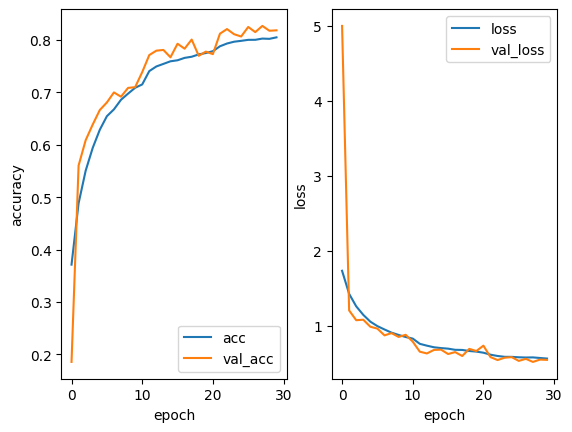

313/313 - 1s - loss: 0.5840 - acc: 0.8121 - 1s/epoch - 4ms/step


In [ ]:
import matplotlib.pyplot as plt

plt.figure()

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')

plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)